In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adadelta, Nadam ,Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import  plot_model ,Sequence
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import tensorflow as tf
from tensorflow.python.keras.losses import binary_crossentropy
from scipy.ndimage import binary_erosion, binary_dilation
from PIL import Image
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from glob import glob  # for getting list paths of image and labels
from random import choice,sample
from matplotlib import pyplot as plt
import cv2 # saving and loading images

In [ ]:
%cd /content/drive/MyDrive/Explo_2024_sem4

/content/drive/MyDrive/Explo_2024_sem4


In [ ]:
!unzip /content/drive/MyDrive/Explo_2024_sem4/Data_for_Explo_2024.zip

Streaming output truncated to the last 5000 lines.
  inflating: COL828_Data_for_Assignment_3/train/images/seq_12_frame039.png  
  inflating: __MACOSX/COL828_Data_for_Assignment_3/train/images/._seq_12_frame039.png  
  inflating: COL828_Data_for_Assignment_3/train/images/seq_6_frame085.png  
  inflating: __MACOSX/COL828_Data_for_Assignment_3/train/images/._seq_6_frame085.png  
  inflating: COL828_Data_for_Assignment_3/train/images/seq_4_frame115.png  
  inflating: __MACOSX/COL828_Data_for_Assignment_3/train/images/._seq_4_frame115.png  
  inflating: COL828_Data_for_Assignment_3/train/images/seq_12_frame011.png  
  inflating: __MACOSX/COL828_Data_for_Assignment_3/train/images/._seq_12_frame011.png  
  inflating: COL828_Data_for_Assignment_3/train/images/seq_12_frame005.png  
  inflating: __MACOSX/COL828_Data_for_Assignment_3/train/images/._seq_12_frame005.png  
  inflating: COL828_Data_for_Assignment_3/train/images/seq_4_frame101.png  
  inflating: __MACOSX/COL828_Data_for_Assignment_3/t

In [ ]:
path = '/content/drive/MyDrive/Explo_2024_sem4/COL828_Data_for_Assignment_3/train/annotations'

for f in os.listdir(path):
    img = Image.open(os.path.join(path,f))
    img = img.convert('RGB')
    r,g,b = img.split()
    r = r.point(lambda i:i*32)
    out = Image.merge('RGB',(r,g,b))
    out.save('/content/drive/MyDrive/Explo_2024_sem4/pixeled_annotations_train/{}'.format(f))

KeyboardInterrupt: 

In [ ]:
path = '/content/drive/MyDrive/Explo_2024_sem4/COL828_Data_for_Assignment_3/val/annotations'

for f in os.listdir(path):
    img = Image.open(os.path.join(path,f))
    img = img.convert('RGB')
    r,g,b = img.split()
    r = r.point(lambda i:i*32)
    out = Image.merge('RGB',(r,g,b))
    out.save('/content/drive/MyDrive/Explo_2024_sem4/pixeled_annotations_valid/{}'.format(f))

In [ ]:
train_img_dir = '/content/drive/MyDrive/Explo_2024_sem4/COL828_Data_for_Assignment_3/train/images/'
train_mask_dir = '/content/drive/MyDrive/Explo_2024_sem4/pixeled_annotations_train/'
train_imgs = os.listdir(train_img_dir)# if you have an error take a look here ...
train_masks = os.listdir(train_mask_dir)
train_imgs= sorted([ i for i in train_imgs ])
train_masks= sorted([ i for i in train_masks ])
print(len(train_imgs))
print(len(train_masks))

1341
1341


In [ ]:
print(train_imgs[:])
print(train_masks[:])

['seq_10_frame000.png', 'seq_10_frame001.png', 'seq_10_frame002.png', 'seq_10_frame003.png', 'seq_10_frame004.png', 'seq_10_frame005.png', 'seq_10_frame006.png', 'seq_10_frame007.png', 'seq_10_frame008.png', 'seq_10_frame009.png', 'seq_10_frame010.png', 'seq_10_frame011.png', 'seq_10_frame012.png', 'seq_10_frame013.png', 'seq_10_frame014.png', 'seq_10_frame015.png', 'seq_10_frame016.png', 'seq_10_frame017.png', 'seq_10_frame018.png', 'seq_10_frame019.png', 'seq_10_frame020.png', 'seq_10_frame021.png', 'seq_10_frame022.png', 'seq_10_frame023.png', 'seq_10_frame024.png', 'seq_10_frame025.png', 'seq_10_frame026.png', 'seq_10_frame027.png', 'seq_10_frame028.png', 'seq_10_frame029.png', 'seq_10_frame030.png', 'seq_10_frame031.png', 'seq_10_frame032.png', 'seq_10_frame033.png', 'seq_10_frame034.png', 'seq_10_frame035.png', 'seq_10_frame036.png', 'seq_10_frame037.png', 'seq_10_frame038.png', 'seq_10_frame039.png', 'seq_10_frame040.png', 'seq_10_frame041.png', 'seq_10_frame042.png', 'seq_10_fr

In [ ]:
from sklearn.model_selection import train_test_split

val_img_dir =  train_img_dir
val_mask_dir = train_mask_dir


train_imgs,val_imgs,train_masks,val_masks =  train_test_split(train_imgs, train_masks, test_size=0.13, random_state=42)


print(len(train_masks))
print(len(val_masks))

1166
175


In [ ]:
class DataGenerator(Sequence):
    'Generates data for Keras'

    def __init__(self, images,image_dir,labels,label_dir ,batch_size=16, dim=(224,224,3) ,shuffle=True):
        'Initialization'
        self.dim = dim
        self.images = images
        self.image_dir = image_dir
        self.labels = labels
        self.label_dir = label_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = list()
        batch_labels = list()

        # Generate data
        for i in list_IDs_temp:
#             degree=np.random.random() * 360
            # Store sample
            img = load_img(self.image_dir + self.images[i] ,target_size=self.dim)
            img = img_to_array(img)/255.
#             img = ndimage.rotate(img, degree)
#             print(img)
            batch_imgs.append(img)
           # Store class
            label = load_img(self.label_dir + self.labels[i] ,target_size=self.dim)
            label = img_to_array(label)[:,:,0]
            label = label != 0
            label = binary_erosion(binary_erosion(label))
            label = binary_dilation(binary_dilation(binary_dilation(label)))
            label = np.expand_dims((label)*1 , axis=2)
            batch_labels.append(label)

        return np.array(batch_imgs,dtype = np.float32 ) ,np.array(batch_labels , dtype = np.float32 )

In [ ]:
train_generator = DataGenerator(train_imgs,train_img_dir,train_masks,train_mask_dir,batch_size=36, dim=(224,224,3) ,shuffle=True)
train_steps = train_generator.__len__()
train_steps

32

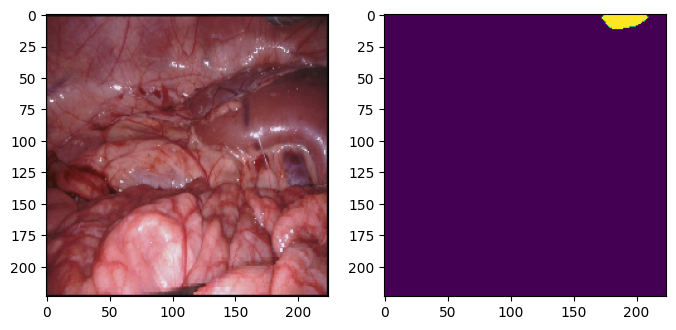

In [ ]:
X,y = train_generator.__getitem__(2)
t = 12

plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(X[t])
plt.subplot(122)
plt.imshow(np.reshape(y[t],(224,224)))

In [ ]:
val_generator = DataGenerator(val_imgs,val_img_dir,val_masks,val_mask_dir,batch_size=36, dim=(224,224,3) ,shuffle=True)
val_steps = val_generator.__len__()
val_steps

4

In [ ]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def Unet(h, w, filters):
# down
    input_layer = Input(shape=(h, w, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv1_out = Dropout(0.3)(conv1_out)  # Added dropout
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv2_out = Dropout(0.3)(conv2_out)  # Added dropout
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv3_out = Dropout(0.4)(conv3_out)  # Increased dropout rate
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7)
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv8 = Dropout(0.3)(deconv8)  # Added dropout
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
    output_layer = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(deconv9)
    # using sigmoid activation for binary classification
    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [ ]:
model = Unet(224 , 224 , 64)
model.summary()

Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 64)         1792      ['image_input[0][0]']         
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 224, 224, 64)         0         ['batch_normalization[0][0]

In [ ]:
def jaccard_distance_loss(y_true, y_pred,smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

# Define the Intersection over Union (IoU) metric
def iou_metric(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1) - intersection
    return (intersection + smooth) / (union + smooth)

In [ ]:
from keras.callbacks import Callback
import numpy as np

class MetricsHistory(Callback):
    def on_train_begin(self, logs=None):
        self.train_losses = []
        self.val_losses = []
        self.train_dice = []
        self.val_dice = []
        self.train_iou = []
        self.val_iou = []

    def on_epoch_end(self, epoch, logs=None):
        self.train_losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.train_dice.append(logs.get('dice_coef'))
        self.val_dice.append(logs.get('val_dice_coef'))
        self.train_iou.append(logs.get('iou_metric'))
        self.val_iou.append(logs.get('val_iou_metric'))

        # Save metrics to numpy files
        np.save('train_losses.npy', np.array(self.train_losses))
        np.save('val_losses.npy', np.array(self.val_losses))
        np.save('train_dice.npy', np.array(self.train_dice))
        np.save('val_dice.npy', np.array(self.val_dice))
        np.save('train_iou.npy', np.array(self.train_iou))
        np.save('val_iou.npy', np.array(self.val_iou))
metrics_history = MetricsHistory()

In [ ]:
model.compile(optimizer='adam', loss=jaccard_distance_loss ,metrics = [dice_coef,iou_metric])
mc = ModelCheckpoint(mode='max', filepath='best_model_final2', monitor='val_dice_coef',save_best_only='True', save_weights_only=False, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_dice_coef', patience=10, restore_best_weights=True)
callbacks = [mc,early_stopping,reduce_lr,metric_history]
print(model.metrics_names)

[]


In [ ]:
results = model.fit(train_generator, steps_per_epoch=train_steps,epochs=40,callbacks=callbacks,validation_data=val_generator,validation_steps=val_steps)

Epoch 1/40
32/32 [==============================] - ETA: 0s - loss: 0.1885 - dice_coef: 0.5484 - iou_metric: 0.8792 
Epoch 1: val_dice_coef improved from -inf to 0.26892, saving model to best_model_final2
32/32 [==============================] - 1254s 37s/step - loss: 0.1885 - dice_coef: 0.5484 - iou_metric: 0.8792 - val_loss: 0.7701 - val_dice_coef: 0.2689 - val_iou_metric: 0.6024 - lr: 0.0010
Epoch 2/40
32/32 [==============================] - ETA: 0s - loss: 0.1072 - dice_coef: 0.6822 - iou_metric: 0.9346
Epoch 2: val_dice_coef improved from 0.26892 to 0.33115, saving model to best_model_final2
32/32 [==============================] - 143s 4s/step - loss: 0.1072 - dice_coef: 0.6822 - iou_metric: 0.9346 - val_loss: 0.2337 - val_dice_coef: 0.3312 - val_iou_metric: 0.8639 - lr: 0.0010
Epoch 3/40
32/32 [==============================] - ETA: 0s - loss: 0.0768 - dice_coef: 0.7687 - iou_metric: 0.9545
Epoch 3: val_dice_coef improved from 0.33115 to 0.46689, saving model to best_model_fina

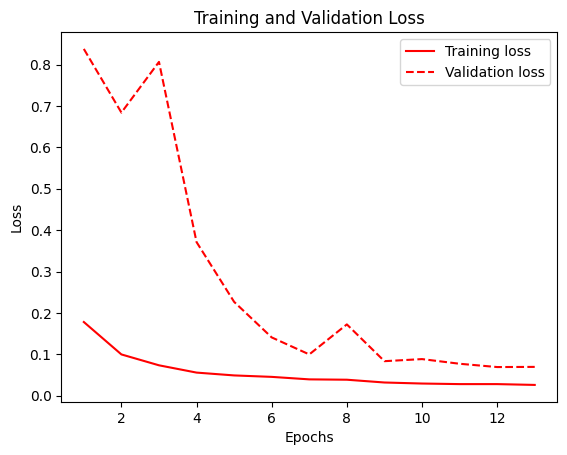

In [ ]:
# Plot for Loss

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'r--', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

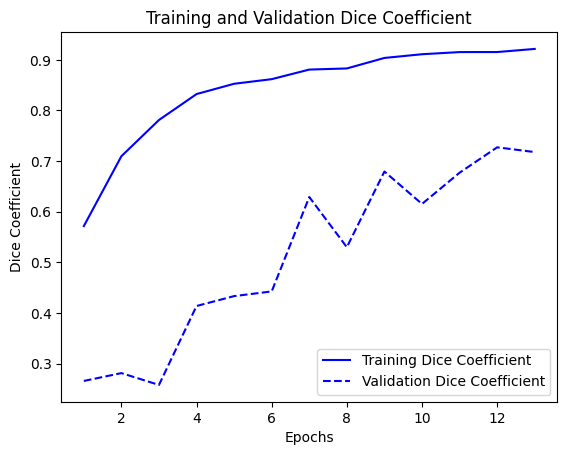

In [ ]:
# Plot for Dice Coefficient
plt.plot(epochs, dice_coef, 'b', label='Training Dice Coefficient')
plt.plot(epochs, val_dice_coef, 'b--', label='Validation Dice Coefficient')
plt.title('Training and Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

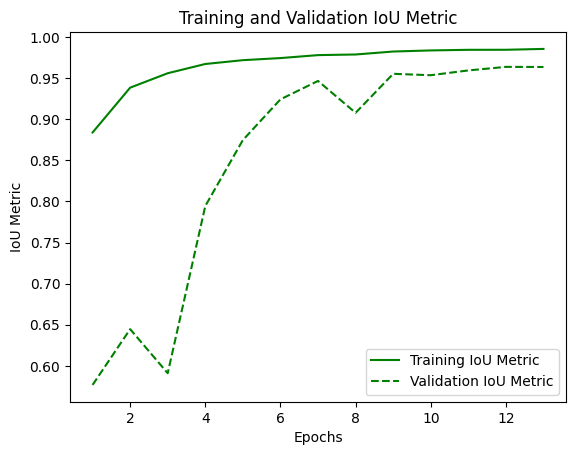

In [ ]:
# Plot for IoU Metric
plt.plot(epochs, iou_metric, 'g', label='Training IoU Metric')
plt.plot(epochs, val_iou_metric, 'g--', label='Validation IoU Metric')
plt.title('Training and Validation IoU Metric')
plt.xlabel('Epochs')
plt.ylabel('IoU Metric')
plt.legend()

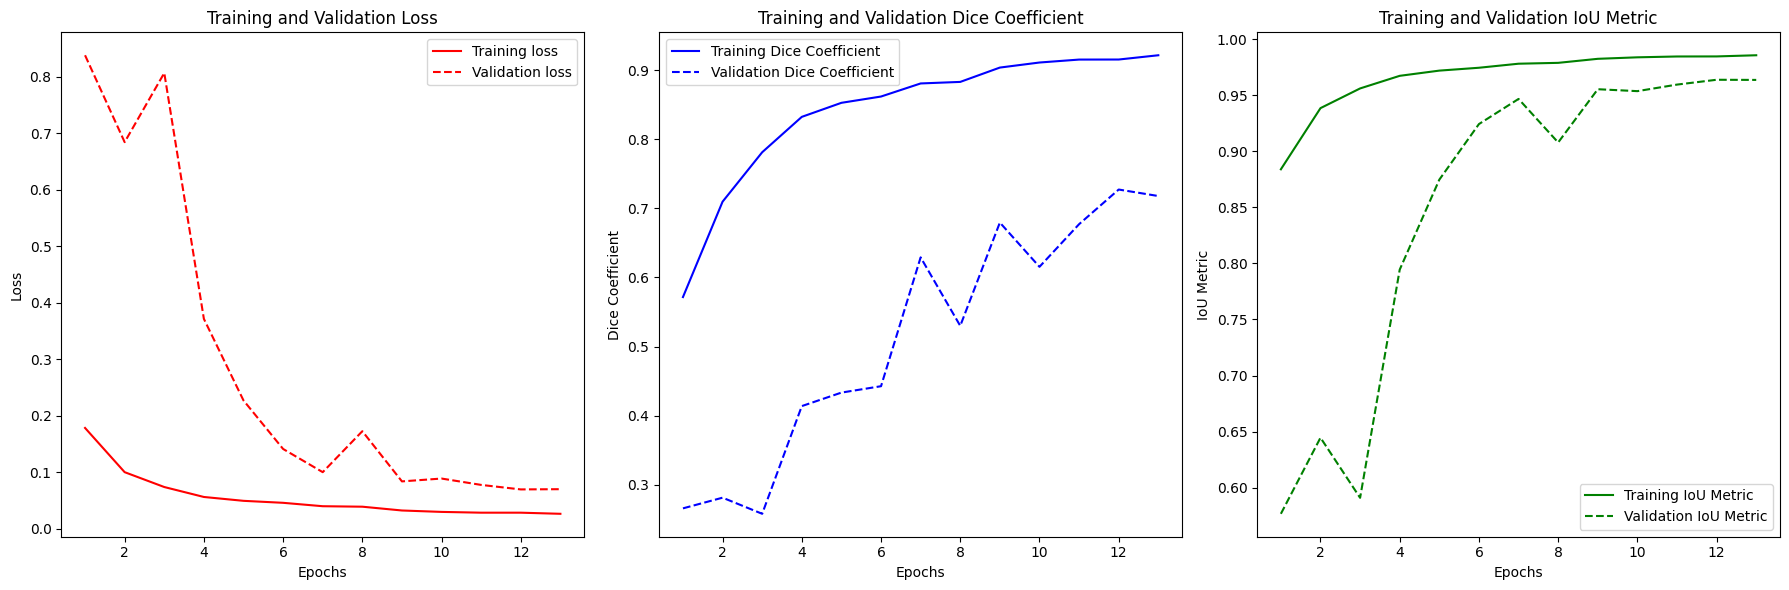

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'results' is the history object returned by model.fit()
loss = results.history["loss"]
val_loss = results.history["val_loss"]

dice_coef = results.history["dice_coef"]
val_dice_coef = results.history["val_dice_coef"]

iou_metric = results.history["iou_metric"]
val_iou_metric = results.history["val_iou_metric"]

epochs = range(1, len(loss) + 1)

# Create subplots
plt.figure(figsize=(18, 6))

# Plot for Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'r--', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for Dice Coefficient
plt.subplot(1, 3, 2)
plt.plot(epochs, dice_coef, 'b', label='Training Dice Coefficient')
plt.plot(epochs, val_dice_coef, 'b--', label='Validation Dice Coefficient')
plt.title('Training and Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

# Plot for IoU Metric
plt.subplot(1, 3, 3)
plt.plot(epochs, iou_metric, 'g', label='Training IoU Metric')
plt.plot(epochs, val_iou_metric, 'g--', label='Validation IoU Metric')
plt.title('Training and Validation IoU Metric')
plt.xlabel('Epochs')
plt.ylabel('IoU Metric')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
###
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/drive/MyDrive/Explo_2024_sem4/best_model_final2', custom_objects={'jaccard_distance_loss': jaccard_distance_loss, 'dice_coef': dice_coef, 'iou_metric': iou_metric})

# Now `model` contains the architecture and weights of your best model

In [ ]:
from tensorflow.keras.utils import Sequence

# Directory paths
test_image_dir = '/content/drive/MyDrive/Explo_2024_sem4/COL828_Data_for_Assignment_3/val/images/'
test_label_dir = '/content/drive/MyDrive/Explo_2024_sem4/pixeled_annotations_valid/'

# List of image and label filenames
test_images = os.listdir(test_image_dir)
test_labels = os.listdir(test_label_dir)


# Instantiate the data generator
test_generator = DataGenerator(
    images=test_images,
    image_dir=test_image_dir,
    labels=test_labels,
    label_dir=test_label_dir,
    batch_size=16,
    dim=(224, 224, 3),
    shuffle=False
)


In [ ]:
# Evaluate the model on the test data
evaluation = model.evaluate(test_generator, verbose=1)

print("Evaluation Results:")
print(f"Loss: {evaluation[0]}")
for i, metric_name in enumerate(model.metrics_names[1:]):
    print(f"{metric_name}: {evaluation[i+1]}")

<ipython-input-11-fc0d5e697510>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluation = model.evaluate_generator(test_generator, verbose=1)


27/27 [==============================] - 812s 30s/step - loss: 0.2329 - dice_coef: 0.1640 - iou_metric: 0.8810
Evaluation Results:
Loss: 0.23288103938102722
dice_coef: 0.16398242115974426
iou_metric: 0.8809767365455627


In [ ]:
def make_prediction(model,image,shape):
    img = img_to_array(load_img(image,target_size=shape))
    img = np.expand_dims(img,axis=0)/255.
    mask = model.predict(img)

    mask = (mask[0] > 0.5)*1
#     print(np.unique(mask,return_counts=True))
    mask = np.reshape(mask,(224,224))
    return mask

(1024, 1280, 3)

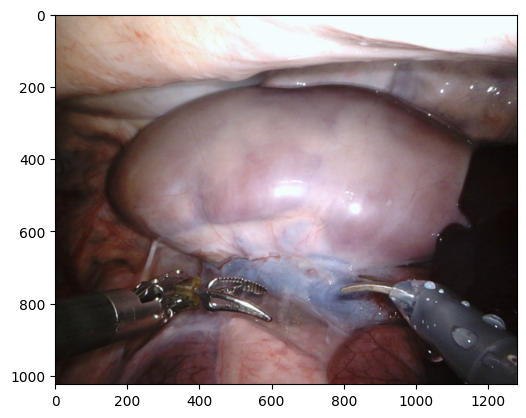

In [ ]:
image = "/content/drive/MyDrive/Explo_2024_sem4/COL828_Data_for_Assignment_3/train/images/seq_10_frame000.png"
img = img_to_array(load_img(image))
plt.imshow(img/255.)
img.shape

1/1 [==============================] - 2s 2s/step
(1024, 1280, 3) (224, 224, 3)


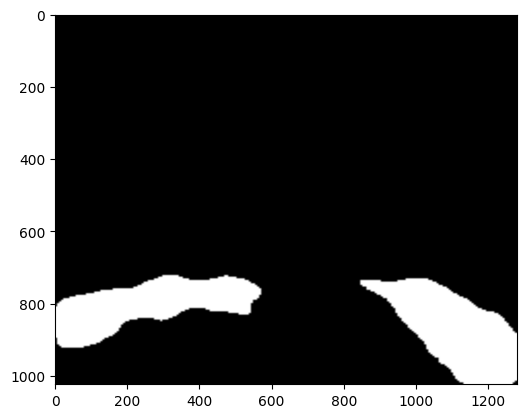

In [ ]:
mask = make_prediction(model,image,(224,224,3))
mask2 = cv2.merge([mask,mask,mask]).astype('float32')
print(img.shape,mask2.shape)
mask2 = cv2.resize(mask2,(img.shape[1],img.shape[0]))
# print(mask.shape)
plt.imshow(mask2)

1/1 [==============================] - 3s 3s/step
(1024, 1280, 3) (224, 224, 3)


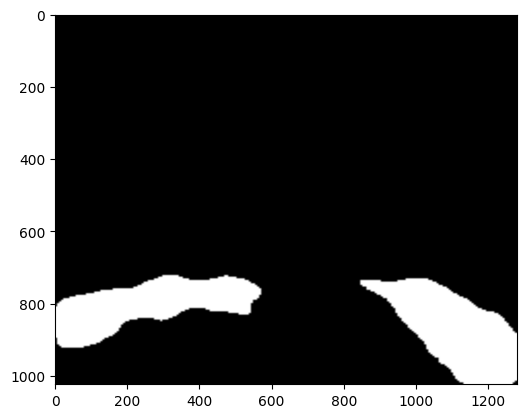

In [ ]:
mask = make_prediction(model,image,(224,224,3))
mask2 = cv2.merge([mask,mask,mask]).astype('float32')
print(img.shape,mask2.shape)
mask2 = cv2.resize(mask2,(img.shape[1],img.shape[0]))
# print(mask.shape)
plt.imshow(mask2)

In [ ]:
h,w = img.shape[:2]
mask_resized = cv2.resize(np.uint8(mask*1),(w,h))
mask_resized = mask_resized != 0
#print(np.unique(mask_resized,return_counts=True))
segment = np.zeros((h,w,3))
segment[:,:,0] = img[:,:,0]*mask_resized
segment[:,:,1] = img[:,:,1]*mask_resized
segment[:,:,2] = img[:,:,2]*mask_resized
segment[np.where((segment == [0,0,0]).all(axis=2))] = [0,0,0]
#img[np.where((img==[255,255,255]).all(axis=2))] = [0,0,0];

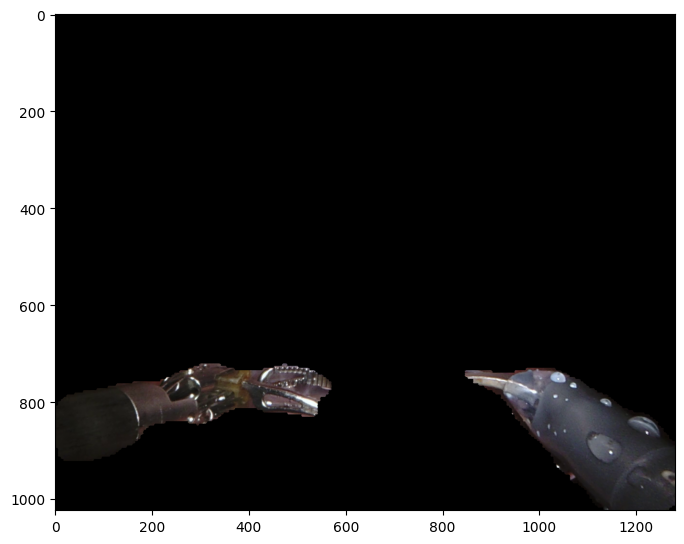

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(segment/255.)

(1024, 1280, 3)

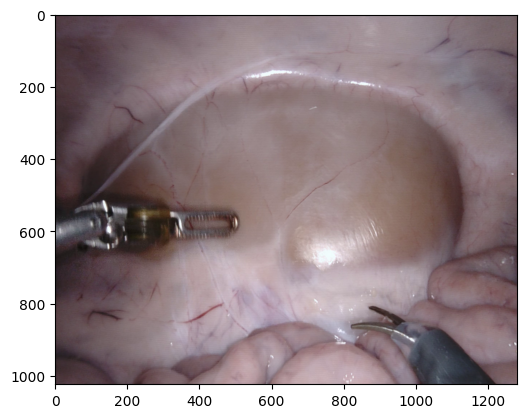

In [ ]:
image = "/content/drive/MyDrive/Explo_2024_sem4/COL828_Data_for_Assignment_3/val/images/seq_15_frame000.png"
img = img_to_array(load_img(image))
plt.imshow(img/255.)
img.shape

1/1 [==============================] - 1s 1s/step
(1024, 1280, 3) (224, 224, 3)


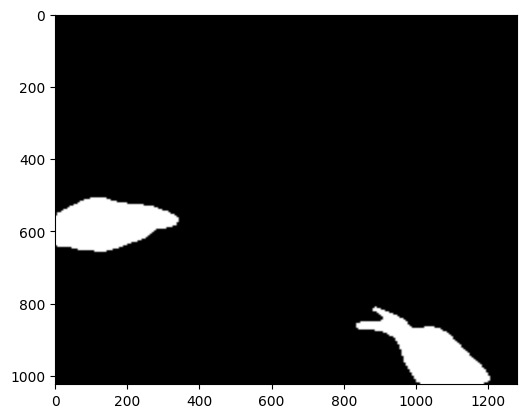

In [ ]:
mask = make_prediction(model,image,(224,224,3))
mask2 = cv2.merge([mask,mask,mask]).astype('float32')
print(img.shape,mask2.shape)
mask2 = cv2.resize(mask2,(img.shape[1],img.shape[0]))
# print(mask.shape)
plt.imshow(mask2)

In [ ]:
h,w = img.shape[:2]
mask_resized = cv2.resize(np.uint8(mask*1),(w,h))
mask_resized = mask_resized != 0
#print(np.unique(mask_resized,return_counts=True))
segment = np.zeros((h,w,3))
segment[:,:,0] = img[:,:,0]*mask_resized
segment[:,:,1] = img[:,:,1]*mask_resized
segment[:,:,2] = img[:,:,2]*mask_resized
segment[np.where((segment == [0,0,0]).all(axis=2))] = [0,0,0]
#img[np.where((img==[255,255,255]).all(axis=2))] = [0,0,0];

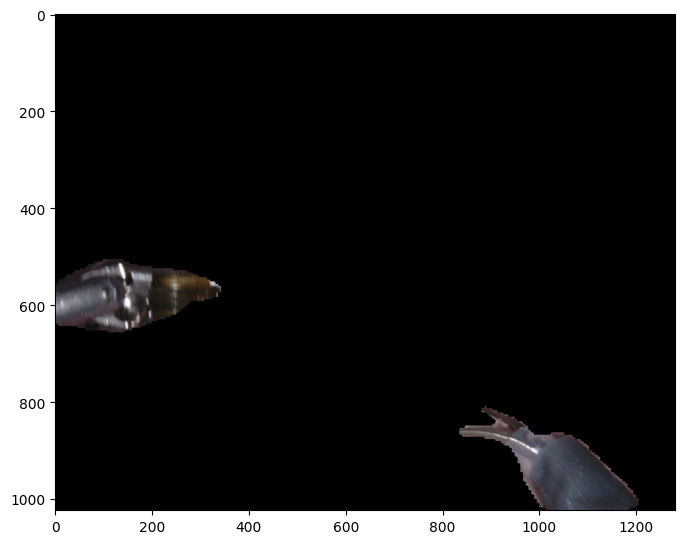

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(segment/255.)

In [ ]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 82.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00


In [ ]:
%%writefile app.py

Writing app.py


In [ ]:
! wget -q -O - ipv4.icanhazip.com

35.194.169.1


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501



npx: installed 22 in 1.712s

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.194.169.1:8501

your url is: https://mighty-boats-sneeze.loca.lt
2024-04-12 10:06:19.485077: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 10:06:19.485127: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 10:06:19.486527: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-12 10:06:20.703524: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-12 10:06:22.406 